<a href="https://colab.research.google.com/github/brian386/ScanChessOnline/blob/master/chessboard_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

(1517, 2653, 3)


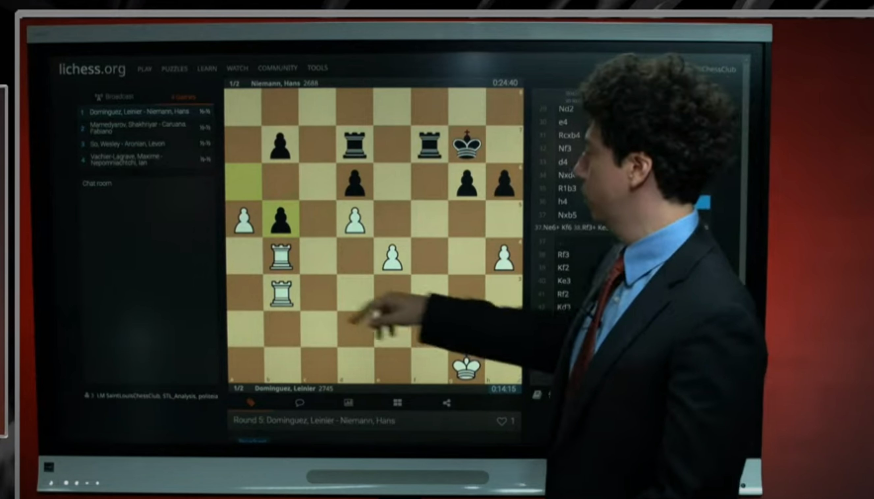

In [26]:
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
import math
img = cv2.imread('./test3.jpg')
print(img.shape)
# img = cv2.resize(img, (500, 500), interpolation=cv2.INTER_AREA)
scale_percent = 500/img.shape[0]
img = cv2.resize(img, (int(img.shape[1] * scale_percent), int(img.shape[0] * scale_percent)))
cv2_imshow(img)

scale_percent = 500/img.shape[0]
img = cv2.resize(img, (int(img.shape[1] * scale_percent), int(img.shape[0] * scale_percent)))

In [27]:
def edge_detect(img, low_threshold=70, high_threshold=200):
  img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  edges = cv2.Canny(img_gray, low_threshold, high_threshold)
  return edges

def get_lines(img):
  rho = 1  # distance resolution in pixels of the Hough grid
  theta = np.pi / 180  # angular resolution in radians of the Hough grid
  threshold = 50  # minimum number of votes (intersections in Hough grid cell)
  min_line_length = 50  # minimum number of pixels making up a line
  max_line_gap = 25  # maximum gap in pixels between connectable line segments

  # Run Hough on edge detected image
  # Output "lines" is an array containing endpoints of detected line segments
  lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]),
                      min_line_length, max_line_gap)
  return lines
def show_lines(img, lines):
  line_image = np.copy(img) * 0  # creating a blank to draw lines on
  line_id = []
  for i,line in enumerate(lines):
    # print(line)
    if len(line) > 0:
      x1, y1, x2, y2 = line[0]
      x1,y1,x2,y2 = int(x1), int(y1), int(x2), int(y2)

      length = math.sqrt((y2-y1)**2 + (x2-x1)**2)
      if(length > 30):
        cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),2)
        line_id.append(line[0])
  cv2_imshow(line_image)
  return line_id
  


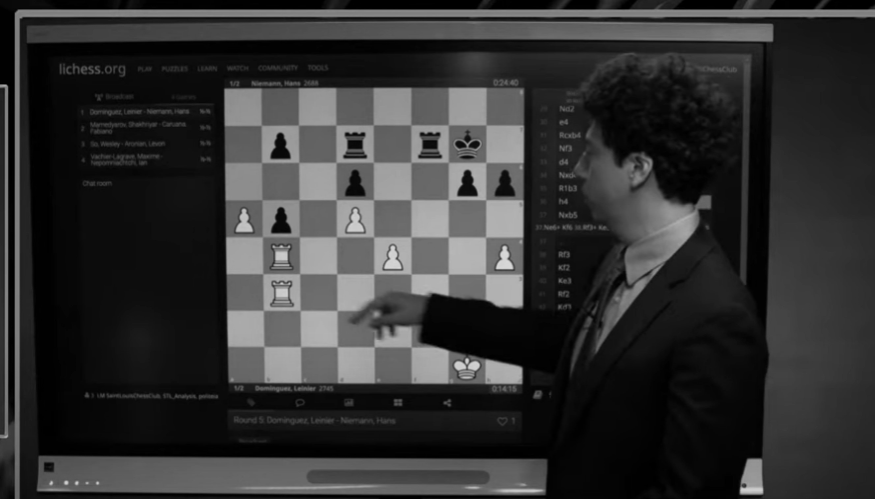

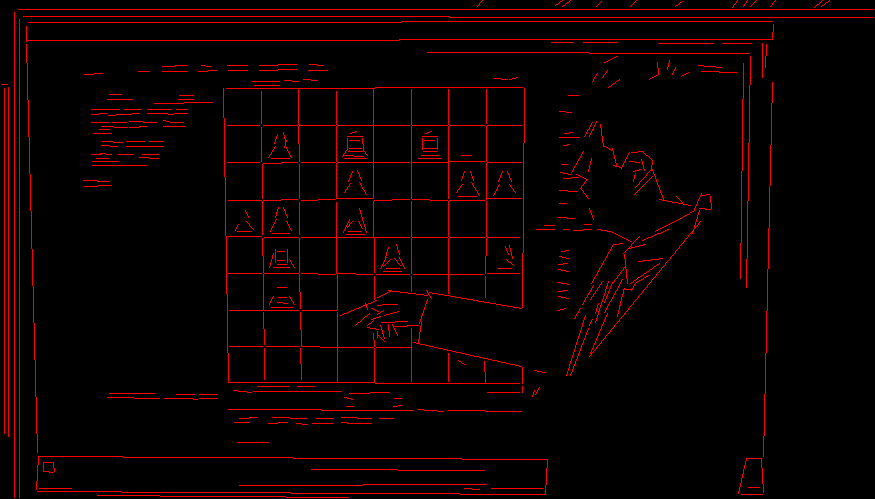

In [28]:
ed = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
drawn_img = np.copy(ed)* 0
#Create default parametrization LSD
lsd = cv2.createLineSegmentDetector(0)

#Detect lines in the image
lines = lsd.detect(ed)[0] #Position 0 of the returned tuple are the detected lines

#Draw detected lines in the image
drawn_img = lsd.drawSegments(drawn_img,lines)

#Show image
cv2_imshow(ed)
cv2_imshow(drawn_img)

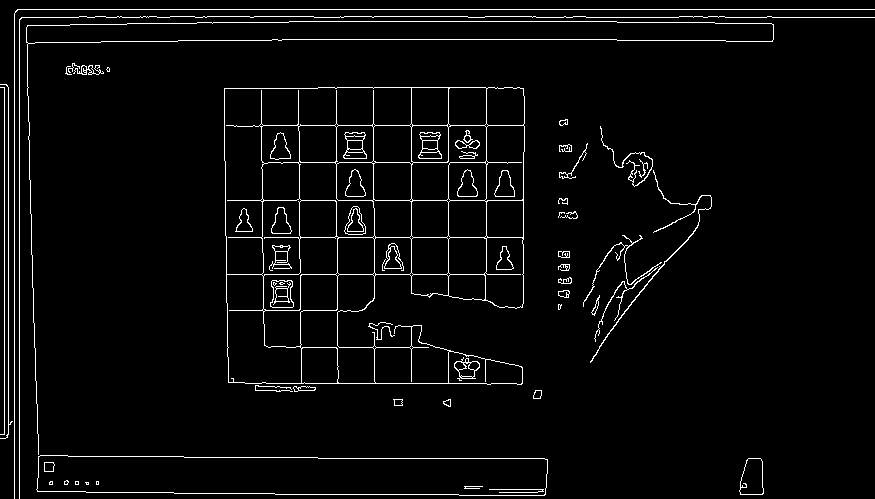

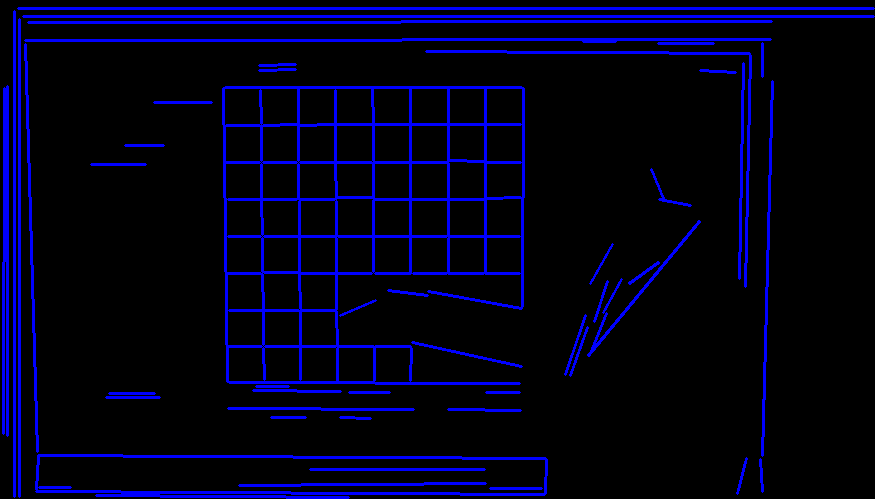

In [29]:
cnt=0
img_edge = edge_detect(img, 40, 300)
W = img_edge.shape[0]
H = img_edge.shape[1]
# lines = get_lines(img_edge)
cv2_imshow(img_edge)
line_id = show_lines(img, lines)


In [30]:
len(line_id)

155

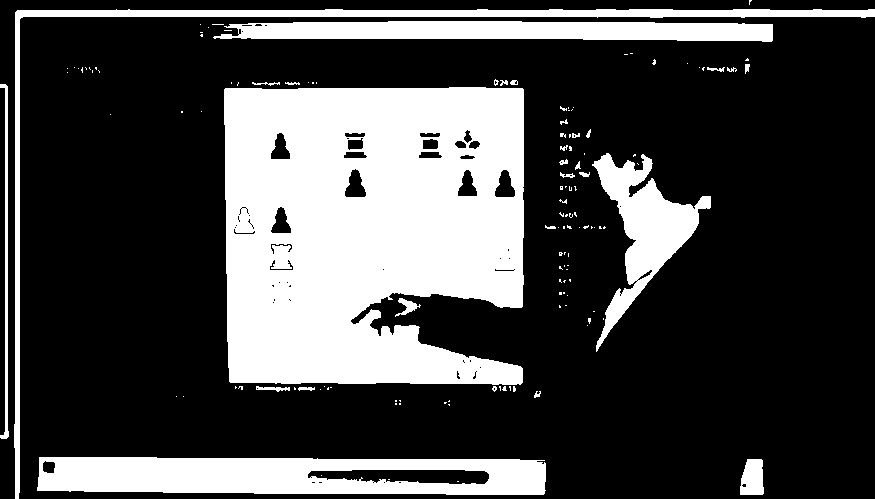

In [31]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
ret2,th2 = cv2.threshold(gray,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
cv2_imshow(th2)

In [32]:
parent = [-1 ]* len(line_id)
size =  [-1 ]* len(line_id)
def make_set(v):
  parent[v] = v
  size[v] = 1

def find_set(v):
  if(v == parent[v]):
    return v
  parent[v] = find_set(parent[v])
  return parent[v]

def union_sets(a,b):
  a = find_set(a)
  b = find_set(b)
  if a != b:
    if(size[a] < size[b]):
      a,b = b,a 
    parent[b] = a
    size[a] += size[b]


In [33]:
from numpy.linalg import norm
import math
import time

def dist(p, p1, p2):
  # t6 = time.time()
  p1p2 = [p2[0] - p1[0], p2[1] - p1[1]]
  p1p = [p[0] - p1[0], p[1] - p1[1]]
  cross = p1p2[0] * p1p[1] - p1p2[1] * p1p[0]
  length = math.sqrt(p1p2[0]**2 + p1p2[1]**2)
  ret = abs(cross)/length
  # t7 = time.time()
  # print(t7-t6)
  return ret

def similar(l1, l2):
  l1x1, l1y1, l1x2, l1y2 = l1
  l2x1, l2y1, l2x2, l2y2 = l2

  #todo: come up with better heuristic
  # t6 = time.time()
  dx1 = dist([l2x1, l2y1], [l1x1, l1y1], [l1x2, l1y2])
  dx2 = dist([l2x2, l2y2], [l1x1, l1y1], [l1x2, l1y2])
  dy1 = dist([l1x2, l1y2], [l2x1, l2y1], [l2x2, l2y2])
  dy2 = dist([l1x1, l1y1], [l2x1, l2y1], [l2x2, l2y2])
  # t7 = time.time()
  # print(t7-t6)
  gamma = 0.25*(dx1 + dx2 + dy1 + dy2) + 0.01
  p = 2
  omega = np.pi/2 * 1/((W*H)**(1/4))
  t_delta = p*omega
  a = math.sqrt((l1y2-l1y1)**2 + (l1x2-l1x1)**2)
  b = math.sqrt((l2y2-l2y1)**2 + (l2x2-l2x1)**2)
  delta = (a + b) * t_delta
  sim = (a/gamma > delta or b/gamma > delta)
  return sim

1.9892969131469727


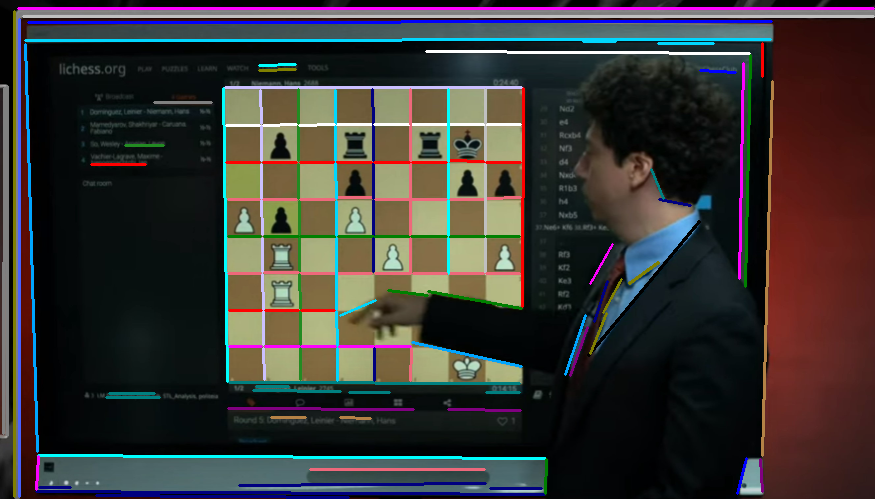

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 10, 13, 14, 15, 16, 3, 8, 19, 20, 19, 22, 23, 24, 25, 8, 27, 28, 9, 19, 31, 19, 19, 31, 19, 36, 37, 31, 39, 37, 39, 42, 43, 39, 45, 39, 47, 39, 45, 47, 43, 39, 31, 37, 55, 56, 47, 58, 59, 39, 59, 39, 43, 64, 56, 56, 37, 68, 43, 68, 43, 72, 9, 42, 55, 42, 68, 45, 56, 25, 59, 25, 25, 37, 72, 72, 47, 56, 89, 43, 72, 68, 43, 72, 59, 59, 56, 31, 68, 68, 42, 42, 25, 55, 25, 37, 72, 37, 9, 47, 72, 59, 56, 9, 56, 55, 25, 55, 72, 64, 121, 55, 123, 9, 19, 126, 127, 25, 19, 43, 37, 132, 55, 8, 25, 55, 137, 138, 139, 140, 141, 142, 138, 144, 145, 146, 147, 148, 8, 150, 16, 146, 9, 16]
defaultdict(<class 'list'>, {0: [array([746.2617 , 458.28128, 737.6617 , 493.31808], dtype=float32)], 1: [array([521.46735, 366.22546, 412.88202, 342.30396], dtype=float32)], 2: [array([223.32408 ,  88.104355, 227.5097  , 381.86597 ], dtype=float32)], 3: [array([428.95142, 291.71512, 521.031  , 308.382  ], dtype=float32), array([388.0155 , 290.18872, 427.06757, 295.44412], dtype

In [34]:
from collections import defaultdict
st= time.time()

for id in range(len(line_id)):
  make_set(id)

t2 = time.time()
for id1 in range(len(line_id)):
  for id2 in range(id1, len(line_id)):
    if similar(line_id[id1], line_id[id2]):  
      union_sets(id1, id2)
t3 = time.time()
print(t3-t2)

colors = [
    (255, 0, 0),    # Red
    (255, 165, 0),  # Orange
    (255, 255, 0),  # Yellow
    (0, 128, 0),    # Green
    (0, 128, 128),  # Teal
    (0, 0, 255),    # Blue
    (128, 0, 128),  # Purple
    (255, 0, 255),  # Magenta
    (128, 0, 0),    # Maroon
    (128, 128, 0),  # Olive
    (128, 128, 128),# Grey
    (192, 192, 192),# Silver
    (255, 255, 255),# White
    (0, 0, 0),      # Black
    (255, 99, 71),  # Tomato
    (255, 192, 203),# Pink
    (255, 215, 0),  # Gold
    (34, 139, 34),  # Forest green
    (70, 130, 180), # Steel blue
    (123, 104, 238) # Medium purple
]

line_image2 = np.copy(img)

groups = defaultdict(list)
for id in range(len(line_id)):
  group_id = find_set(id)
  c = colors[group_id%len(colors)]
  line = line_id[id]
  groups[group_id].append(line)
  x1, y1, x2, y2 = line
  x1,y1,x2,y2 = int(x1), int(y1), int(x2), int(y2)
  cv2.line(line_image2,(x1,y1),(x2,y2),c,2)

cv2_imshow(line_image2)

print(parent)
print(groups)

In [35]:
t4 = time.time()
print(similar([0,0,1,1], [2.2,2.3,3,3]))
t5 = time.time()
print(t5-t4)

True
0.0012211799621582031


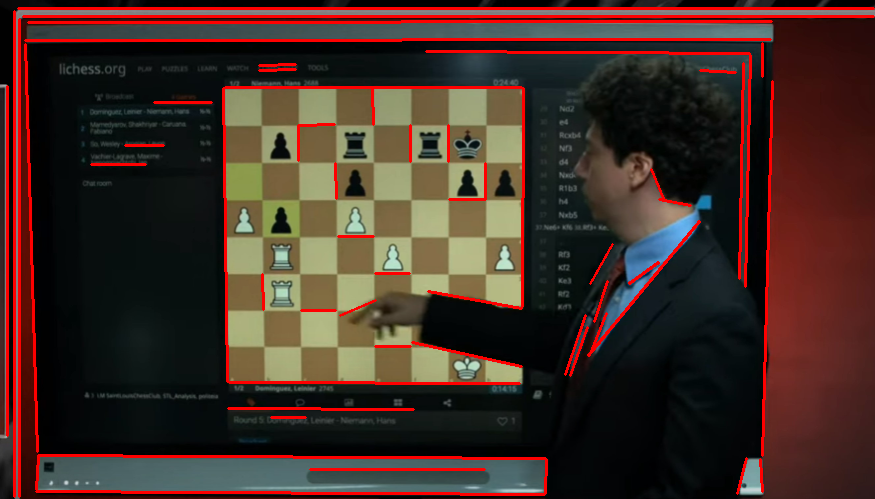

In [36]:
line_image3 = np.copy(img)
merged_lines = []
for group_id in groups:
  group = groups[group_id]
  max_len = 0
  max_idx = 0
  for i,line in enumerate(group):
    length = (line[3]-line[1])**2 + (line[2]-line[0])**2
    if length > max_len:
      max_len = length
      max_idx = i
  line = group[max_idx]
  merged_lines.append(line)
  cv2.line(line_image3,(int(line[0]),int(line[1])),(int(line[2]),int(line[3])),(0,0,255),2)
  
cv2_imshow(line_image3)

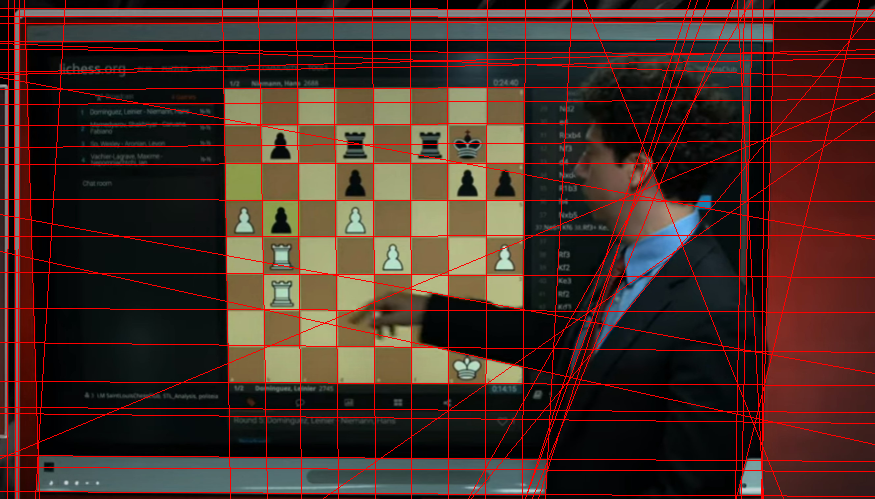

In [37]:
from pickle import TUPLE1
class Line():
  def __init__(self, point, vector):
    self.point = point
    self.vector = vector

full_lines = []
def magnitude(v):
  return math.sqrt(v[0]**2 + v[1]**2)

def find_intersection(l1, l2):
  x1,y1 = l1.point
  u1,v1 = l1.vector
  x2,y2 = l2.point
  u2,v2 = l2.vector
  det = -u1*v2 + v1*u2
  if abs(det) < 0.0000001: 
    return 1000000000, [1000000000, 1000000000]
  t = (-v2*(x2-x1) + u2*(y2-y1))/det
  return [x1 + t*u1, y1 + t*v1]

for line in merged_lines:
  d = [line[2] - line[0], line[3] - line[1]]
  full_lines.append(Line([line[0], line[1]], d))

line_image4 = np.copy(img)

for line in full_lines:
  cv2.line(line_image4,(int(line.point[0]+500*line.vector[0]), int(line.point[1]+500*line.vector[1])),(int(line.point[0] - 500*line.vector[0]), int(line.point[1] - 500*line.vector[1])),(0,0,255),1)
cv2_imshow(line_image4)


In [38]:
# import torch
# from torchvision import transforms
# model = torch.load('resnet18.pth', map_location=torch.device('cpu'))
# model.eval()

# def predict_image(im):
#   edges = edge_detect(im)
#   edges = cv2.cvtColor(edges, cv2.COLOR_GRAY2RGB)
#   pred = model(transforms.ToTensor()(edges).unsqueeze(0))
#   prob = torch.sigmoid(pred).item()
#   value = 1 if prob > 0.5 else 0
#   return value

In [39]:
templates = [np.array(
    [[0, 0, 0, 0, 255, 255, 255, 255],
      [0, 0, 0, 0, 255, 255, 255, 255],
      [0, 0, 0, 0, 255, 255, 255, 255],
      [0, 0, 0, 0, 255, 255, 255, 255],
      [255, 255, 255, 255, 0, 0, 0, 0],
      [255, 255, 255, 255, 0, 0, 0, 0],
      [255, 255, 255, 255, 0, 0, 0, 0],
      [255, 255, 255, 255, 0, 0, 0, 0]],
    dtype=np.uint8
), np.array(
    [[255, 255, 255, 255, 0, 0, 0, 0],
      [255, 255, 255, 255, 0, 0, 0, 0],
      [255, 255, 255, 255,0, 0, 0, 0],
      [255, 255, 255, 255,0, 0, 0, 0],
      [0, 0, 0, 0, 255, 255, 255, 255],
      [0, 0, 0, 0, 255, 255, 255, 255],
      [0, 0, 0, 0, 255, 255, 255, 255],
      [0, 0, 0, 0, 255, 255, 255, 255]],
    dtype=np.uint8
)]

# templates = [np.array(
#     [[0, 0, 0, 255, 255, 255],
#     [0, 0, 0, 255, 255, 255],
#     [0, 0, 0, 255, 255, 255],
#     [255, 255, 255, 0, 0, 0],
#     [255, 255, 255, 0, 0, 0],
#     [255, 255, 255,  0, 0, 0]],
#     dtype=np.uint8
# ), np.array(
#     [[255, 255, 255,  0, 0, 0],
#     [255, 255, 255,  0, 0, 0],
#     [255, 255, 255, 0, 0, 0],
#     [0, 0, 0, 255, 255, 255],
#     [0, 0, 0, 255, 255, 255],
#     [0, 0, 0, 255, 255, 255]],
#     dtype=np.uint8
# )]

In [40]:
def detect_lattice(im):
  gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
  th =  cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,21,2)
  for template in templates:
    res = cv2.matchTemplate(th,template,cv2.TM_CCORR_NORMED)
    loc = np.where( res >= 0.9)
    if len(loc[0]) > 0 or len(loc[1]) > 0:
      return True
  return False
  # ret, corners = cv2.findChessboardCorners(th, (3,3), None)
  # cv2.drawChessboardCorners(th, (3,3), corners,ret)


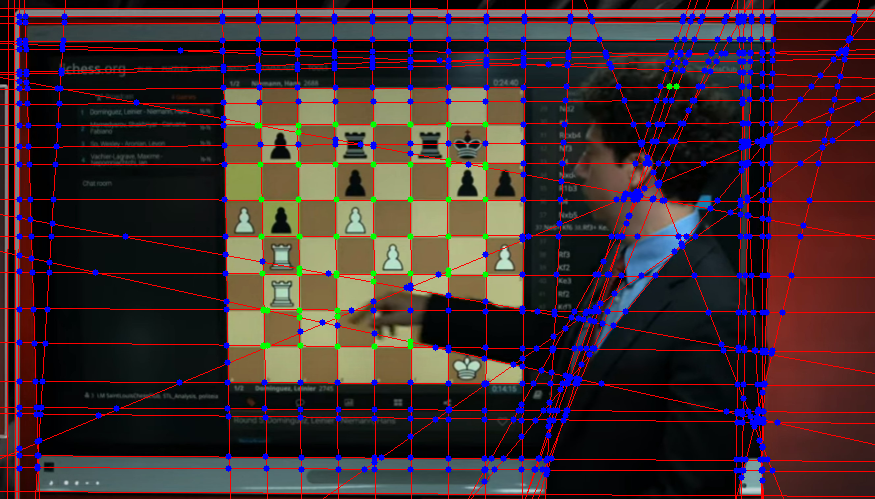

In [41]:
inter_images = []
lattice_points = []
for i in range(len(full_lines)):
  for j in range(i+1, len(full_lines)):
    point_inter = find_intersection(full_lines[i], full_lines[j])
    if(point_inter[0] >= 16 and point_inter[0] < H-16 and point_inter[1] >= 16 and point_inter[1] < W-16):
      
      roi = img[int(point_inter[1])-12: int(point_inter[1])+12, int(point_inter[0])-12: int(point_inter[0])+12]
      if(len(roi) == 0):
        print("empty")
        print(point_inter[0], point_inter[1])
      inter_images.append(roi)

      is_lattice = detect_lattice(roi)
      if is_lattice == 1:
        cv2.circle(line_image4, (int(point_inter[0]), int(point_inter[1])), 3, (0, 255, 0), -1)
        lattice_points.append(point_inter)
      else:
        cv2.circle(line_image4, (int(point_inter[0]), int(point_inter[1])), 3, (255, 0, 0), -1)
cv2_imshow(line_image4)

In [42]:
# import torch
# from torchvision import transforms
# model = torch.load('resnet18.pth', map_location=torch.device('cpu'))
# model.eval()
# for im in inter_images:
#   edges = edge_detect(im)
#   edges = cv2.cvtColor(edges, cv2.COLOR_GRAY2RGB)
#   cv2_imshow(edges)
#   pred = model(transforms.ToTensor()(edges).unsqueeze(0))
#   prob = torch.sigmoid(pred).item()
#   value = 1 if prob > 0.5 else 0
#   print(value)


In [43]:
len(lattice_points)
type(lattice_points[0])
        

list

# Scoring


In [44]:
from sklearn.cluster import DBSCAN
clustering = DBSCAN(eps=90, min_samples=3).fit(lattice_points)

clustering.labels_

array([ 0,  0,  0,  0,  0,  0,  0, -1, -1,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0])

In [45]:
labels = clustering.labels_
clusters = [[] for _ in range(max(labels)+1)]

for point, cluster in zip(lattice_points, labels):
  if cluster >= 0:
    clusters[cluster].append(point)

clusters.sort(key=lambda x: -len(x))
biggest_cluster = clusters[0]
biggest_cluster = np.array([np.array([num for num in nums]) for nums in biggest_cluster])

hull = cv2.convexHull(biggest_cluster)
area = cv2.contourArea(hull)

In [46]:
def get_centroid(arr):
    length = arr.shape[0]
    sum_x = np.sum(arr[:, 0])
    sum_y = np.sum(arr[:, 1])
    return sum_x/length, sum_y/length

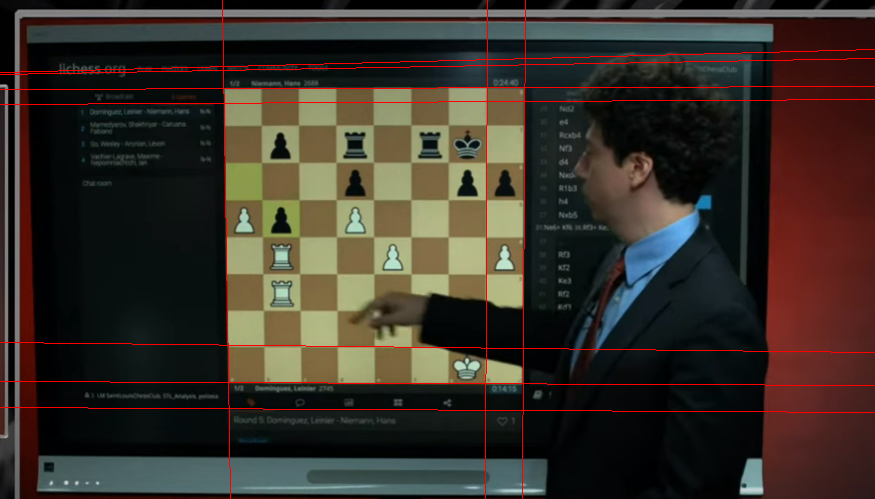

In [47]:
grid_len = math.sqrt(area)/7
filtered_lines = []
def get_closest_lattice(line, points):
  p1 = line.point
  p2 = [line.vector[0] + line.point[0], line.vector[1] + line.point[1]]
  closest = 1000000000.0
  for pt in points:
    d = dist(pt, p1, p2)
    closest = min(closest, d)
  return closest 

line_image5 = np.copy(img)

for line in full_lines:
  if(get_closest_lattice(line, biggest_cluster) < 2 * grid_len and dist(get_centroid(biggest_cluster), line.point, [line.point[0] + line.vector[0], line.point[1] + line.vector[1]]) > 3.5 * grid_len):
      cv2.line(line_image5,(int(line.point[0]+500*line.vector[0]), int(line.point[1]+500*line.vector[1])),(int(line.point[0] - 500*line.vector[0]), int(line.point[1] - 500*line.vector[1])),(0,0,255),1)
      filtered_lines.append(line)
cv2_imshow(line_image5)

centroid = get_centroid(biggest_cluster)

In [48]:
def reorder_quadrilateral(points):
    # Calculate the centroid of the quadrilateral
    cx = np.mean(points[:, 0])
    cy = np.mean(points[:, 1])

    # Calculate the angle between each point and the centroid
    angles = np.arctan2(points[:, 1] - cy, points[:, 0] - cx)

    # Sort the points based on their angles in a clockwise direction
    sorted_idx = np.argsort(angles)

    # Reorder the points to get the top-left, top-right, bottom-right, and bottom-left points
    top_left_idx = sorted_idx[:1]
    top_right_idx = sorted_idx[1:2]
    bottom_right_idx = sorted_idx[2:3]
    bottom_left_idx = sorted_idx[3:]

    reordered_points = np.concatenate([
        points[top_left_idx],
        points[top_right_idx],
        points[bottom_right_idx],
        points[bottom_left_idx]
    ])

    return reordered_points

In [49]:
cnt=0
filtered_quads = []
for i in range(len(filtered_lines)):
  for j in range(i+1, len(filtered_lines)):
    for k in range(j+1, len(filtered_lines)):
      for l in range(k+1, len(filtered_lines)):
        lines = [filtered_lines[i], filtered_lines[j], filtered_lines[k], filtered_lines[l]]
        inter_points = []
        num_inters = [0] * 4
        for li in range(len(lines)):
          for lj in range(li+1, len(lines)):
            inter_point = find_intersection(lines[li], lines[lj])
            if(inter_point[0] >= 16 and inter_point[0] < H-16 and inter_point[1] >= 16 and inter_point[1] < W-16):
              inter_points.append(inter_point)
              num_inters[li] += 1
              num_inters[lj] += 1

        if(len(inter_points) != 4):
          continue

        if(num_inters[0] != 2 or num_inters[1] != 2 or num_inters[2] != 2 or num_inters[3] != 2):
          continue
        #shoelace
        inter_points = reorder_quadrilateral(np.array(inter_points))
        contourArea = inter_points[0][0]*inter_points[1][1] + inter_points[1][0]*inter_points[2][1] + inter_points[2][0]*inter_points[3][1] + inter_points[3][0]*inter_points[0][1] - inter_points[0][1]*inter_points[1][0]- inter_points[0][1]*inter_points[1][0] - inter_points[0][1]*inter_points[1][0] - inter_points[0][1]*inter_points[1][0]
        contourArea /= 2

        if contourArea < area:
          continue

        filtered_quads.append(inter_points)
        cnt +=1
        # line_image6 = np.copy(img)
        # for line in lines:
        #   cv2.line(line_image6,(int(line.point[0]+500*line.vector[0]), int(line.point[1]+500*line.vector[1])),(int(line.point[0] - 500*line.vector[0]), int(line.point[1] - 500*line.vector[1])),(0,0,255),1)
        # cv2_imshow(line_image6)
cnt

36

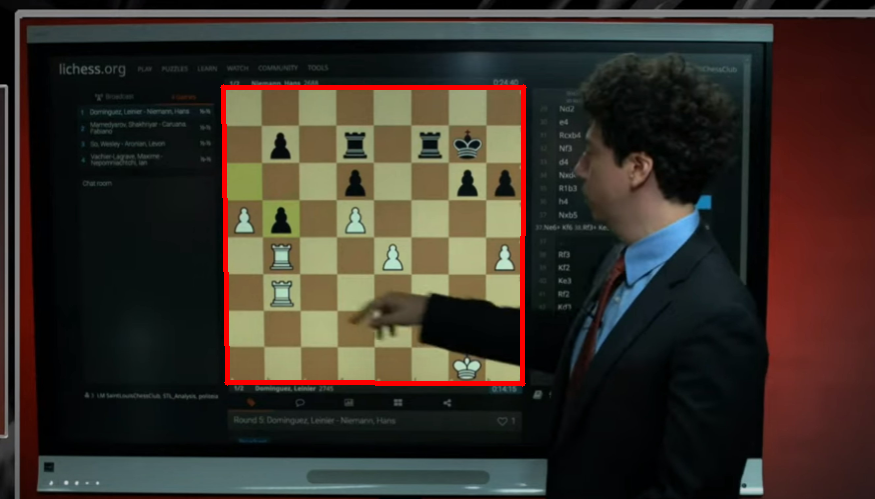

In [50]:
#quads are in clockwise order

def get_score(quad, lattice_points):
  SIZE = 480
  GRID_LEN = SIZE/8
  M = cv2.getPerspectiveTransform(np.array(quad, dtype=np.float32), np.array([[0,0], [0, SIZE], [SIZE, SIZE], [SIZE, 0]], dtype=np.float32))
  transformed_points = np.squeeze(cv2.perspectiveTransform(lattice_points.reshape(-1, 1, 2), M), 1)
  # print(transformed_points)
  score = 0
  for i in range(1,7):
    for j in range(1,7):
      r = GRID_LEN * i
      c = GRID_LEN * j
      min_d = 1000000000.0
      for pt in transformed_points:
        d = math.sqrt((r-pt[0])**2 + (c-pt[1])**2)
        min_d = min(d, min_d)
      score += max(GRID_LEN/2-min_d, 0)
  return score

final_quad = []
max_score = 0
for quad in filtered_quads:
  cur_score = get_score(quad, biggest_cluster)
  if cur_score > max_score:
    final_quad = quad
    max_score = cur_score

final_img = np.copy(img)
for pt in final_quad:
  cv2.circle(final_img, (int(pt[0]), int(pt[1])), 3, (0, 0, 255), -1)

cv2.polylines(final_img,[np.array(final_quad, dtype=np.int32)],True,(0,0,255), 3)

cv2_imshow(final_img)